# **Trabajo Parcial - Inteligencia Artificial CC62**


> Integrantes:
* Cano Chocce, Samuel Esteban –  U202116508
* Guerrero Icochea, Nicolas Miguel – U202115535
* Puglisevich Vergara, Eduardo Elias – U20201E850


> Seccion: CC62

In [57]:
!pip install spacy -q
!python -m spacy download es_core_news_sm -q
!pip install emoji -q

2023-11-20 03:04:59.215858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 03:04:59.215938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 03:04:59.215985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 03:05:00.415450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 101.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
from pandas.core.algorithms import unique
import re

## Análisis EDA

### 1. Recolección de los datos

In [59]:
!gdown 1jJ7pSJueHkTw7FI8d19wo5TfhTMk4c5M

Downloading...
From: https://drive.google.com/uc?id=1jJ7pSJueHkTw7FI8d19wo5TfhTMk4c5M
To: /content/tiktok_dataset.csv
100% 63.6k/63.6k [00:00<00:00, 99.3MB/s]


In [60]:
df=pd.read_csv('tiktok_dataset.csv', header=0, encoding='utf8')

### 2. Previsualización de los datos

In [61]:
df.head()

,text,diggCount,replyCommentTotal,createTimeISO,label
0,😏😏,0,0.0,2023-02-18T21:00:37.000Z,1
1,@effy.00 😂,0,0.0,2022-12-13T18:06:52.000Z,0
2,"jingle bell, jingle bell, jingle bell rock… 👯‍...",2,0.0,2022-12-08T08:26:40.000Z,1
3,@betterwayso15 tus friends? 😂,0,1.0,2022-12-04T14:09:30.000Z,1
4,super !,1,0.0,2022-12-03T20:48:49.000Z,1


Cambiamos el formato de la columna *createTimeISO*  para que tenga un formato de tiempo.

In [62]:
df['createTimeISO']=pd.to_datetime(df['createTimeISO'])

In [63]:
df.head()

,text,diggCount,replyCommentTotal,createTimeISO,label
0,😏😏,0,0.0,2023-02-18 21:00:37+00:00,1
1,@effy.00 😂,0,0.0,2022-12-13 18:06:52+00:00,0
2,"jingle bell, jingle bell, jingle bell rock… 👯‍...",2,0.0,2022-12-08 08:26:40+00:00,1
3,@betterwayso15 tus friends? 😂,0,1.0,2022-12-04 14:09:30+00:00,1
4,super !,1,0.0,2022-12-03 20:48:49+00:00,1


In [64]:
copy=df.copy()
copy.sort_values(by='createTimeISO', inplace=True)

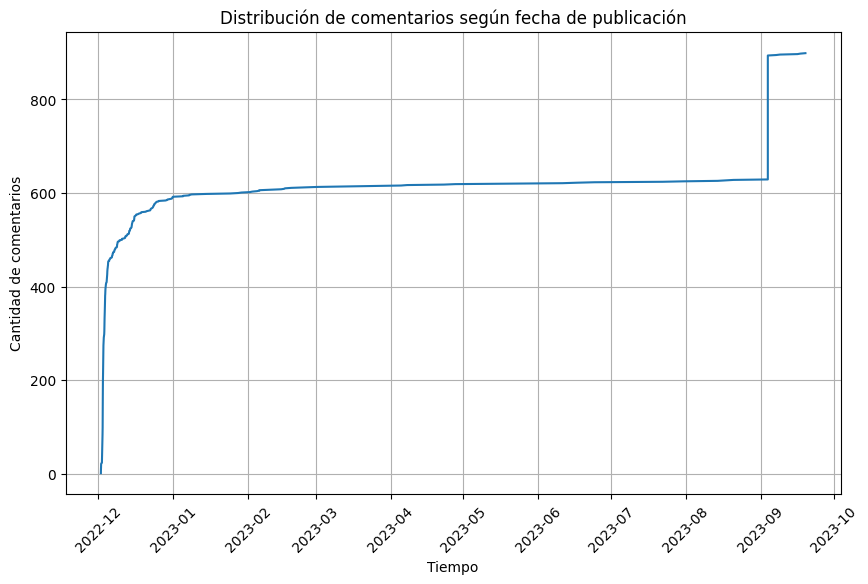

In [65]:
plt.figure(figsize=(10, 6))  # Establece el tamaño de la figura según tus preferencias

# Utiliza la columna de tiempo en el eje x y otra columna (por ejemplo, 'valor') en el eje y
copy['conteo_comentarios'] = range(1, len(copy) + 1)

plt.plot( copy['createTimeISO'], copy['conteo_comentarios'])

# Personaliza las etiquetas de los ejes y el título del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de comentarios')
plt.title('Distribución de comentarios según fecha de publicación')

# Rotación de las etiquetas del eje x para mejorar la legibilidad si es necesario
plt.xticks(rotation=45)

# Muestra el gráfico
plt.grid(True)  # Activa las líneas de la cuadrícula si lo deseas
plt.show()


Vemos que  hubo un incremento en la cantidad de comentarios. Esto es debido  a la reciente interacción que h emos incentivado en la caja de comentarios del video de tiktok para poder tener un dataset de comentarios más grande para nuestro proyecto

### 3. Normalización de los datos

Solo guardamos los datos que se utilizarán para el entrenamiento: 'Text' y 'label'.

In [66]:
df=df[['text', 'label']]
df

,text,label
0,😏😏,1
1,@effy.00 😂,0
2,"jingle bell, jingle bell, jingle bell rock… 👯‍...",1
3,@betterwayso15 tus friends? 😂,1
4,super !,1
...,...,...
894,Desde que dijo “me da igual juntarme cooon..” 😂,0
895,@sarita.vll si hubieses continuado en la upc xd 😂,1
896,confirmo soy un huancaino en la UPC 🤑,1
897,El primer ciclo es el más sencillo en la upc🧍🏻‍♀️,0


In [67]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [68]:
#@title Separar emojis
import emoji

def separar_palabras_y_emojis(cadena):
    tokens = []

    i = 0
    while i < len(cadena):
        if cadena[i] in emoji.EMOJI_DATA:
            j = i + 1
            while j < len(cadena) and cadena[j] in emoji.EMOJI_DATA:
                j += 1
            tokens.extend(cadena[i:j])
            i = j
        else:
            j = i + 1
            while j < len(cadena) and cadena[j] not in emoji.EMOJI_DATA and cadena[j].isalnum():
                j += 1
            tokens.append(cadena[i:j])

            i = j

    # Une los tokens con espacios y devuelve la cadena resultante
    return ' '.join(tokens)

# Ejemplo de uso
cadena = "🫶🏻🫶🏻🫶🏻"
resultado = separar_palabras_y_emojis(cadena)
print(resultado)
# Resultado: hola 🤮 hola 🤮 hola


🫶 🏻 🫶 🏻 🫶 🏻


In [69]:
df['text']=df['text'].apply(separar_palabras_y_emojis)
for w in df['text']: print(w)

😏 😏
@effy .00   😂
jingle  bell ,  jingle  bell ,  jingle  bell  rock …   👯 ‍ ♀ ️ 👯 ‍ ♀ ️
@betterwayso15  tus  friends ?   😂
super   !
SLAYYYY
Amazing  obviiii   🥰
@issa334w   🥺
ya  pero  porque  nadie  habla  de  la  coordinación  que  tienen   <33
Felicidades ! ! !  No  es  fácil  lidiar  con  los  exámenes ,  trabajos  grupales  y  encima  hacer  una  coreo
me  asombra  que  tengan  no  solo  igual  la  ropa  si  no  el  cabello  tbm  jajja
que  risa  como  critican  los  mortales
Lindasaaaaasssss
Hermosas   🥰 !  Se  dieron  el  tiempo  de  armar  coreo  entre  clases  y  trabajos .  Excelente  chicas   💜
Son  de   @vabe .pe  una  academia  de  baile .  Y  bailaron  muy  lindo 🥰 🥰  con  súper  actitud
son  de   @vabe .pe  escuela  de  baile  de   @valegoonzz  todas  hermosas  y  con  vibras  super  lindas ,excelente  lugar  para  aprender  a  bailaaar
el  buscador  JAKAJAKJAA
son  de   @vabe .pe  EL  MEJOR  LUGAR  SI  QUIEREN  APRENDER  A  BAILAR   😍
la  coreo  es  de  fit  dance   ,

In [70]:
#@ title todos los emojis
all_emojis=[]
for doc in df['text']:
    for w in doc:
        if emoji.is_emoji(w): all_emojis.append(w)
print("Total de emojis en el dataset: ", len(unique(all_emojis)))

print(all_emojis)

Total de emojis en el dataset:  102
['😏', '😏', '😂', '👯', '♀', '👯', '♀', '😂', '🥰', '🥺', '🥰', '💜', '🥰', '🥰', '😍', '😁', '😍', '🥲', '🤔', '😊', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😅', '😂', '😂', '😂', '😂', '😂', '😂', '🤣', '🤌', '🏼', '\U0001fae0', '🤗', '😱', '💀', '✨', '☺', '❤', '😂', '😂', '😅', '🥰', '🥰', '😂', '😅', '❤', '🔥', '❤', '🔥', '❤', '🔥', '🥰', '😮', '💨', '❤', '🥰', '🥰', '🥺', '\U0001faf6', '🏼', '🥰', '❤', '🩹', '✨', '❤', '😍', '\U0001fae0', '🥰', '🥰', '🥰', '🥰', '🥰', '\U0001fa77', '🥰', '🥰', '😂', '😂', '😂', '😂', '🤌', '🏼', '🤌', '🏼', '🤌', '🏼', '🤌', '🏻', '🤌', '🏻', '🤌', '🏻', '🥺', '\U0001faf6', '🏼', '🥰', '🥰', '😂', '🤔', '😂', '😭', '😂', '😂', '😂', '🥰', '💞', '💞', '💞', '🤣', '👏', '👏', '👏', '👀', '😂', '🥰', '💖', '\U0001faf6', '🏻', '✨', '😂', '😂', '😂', '😅', '🥰', '🤭', '🤭', '🤣', '🤣', '💀', '🥺', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😅', '😅', '😅', '😳', '😳', '😳', '🥰', '🥰', '🥰', '😂', '🥺', '👌', '🏾', '🥰', '🦾', '☺', '☀', '☀', '☀', '😂', '😎', '😍', '😂', '😂', '😂', '😅', '😂', '😏', '🥰', '👌',

In [71]:
#@title Diccionario de emojis
emoji_dict = {
    "😏": " atrevido",
    "😂": " risa de burla",
    "👯": " Bailando en pareja",
    "♀": " Símbolo femenino",
    "🥰": " enamorado",
    "🥺": " suplicante",
    "💜": " Color morado, símbolo de amor",
    "😍": " Ojos de corazón, admiración",
    "😁": " Sonriendo con alegría",
    "🥲": " Emocionado con lágrimas",
    "🤔": " Pensativo",
    "😊": " Sonriendo con ternura",
    "😅": " Riendo nerviosamente",
    "🤣": " Carcajadas intensas",
    "🤌": " frustración desacuerdo",
    "🏼": " ",
    "🫠": " sarcarmo",
    "🤗": " Abrazo amistoso",
    "😱": " Gritando de sorpresa",
    "💀": " Calavera",
    "✨": " Brillante, mágico",
    "☺": " sonriente",
    "❤": " Corazón rojo",
    "🔥": " Fuego, algo asombroso",
    "😮": " Cara asombrada",
    "💨": " Viento",
    "🫶": " ánimo y amor",
    "🩹": " fuerzas curita",
    "🩷": " amor corazón",
    "🏻": " ",
    "😭": " Llorando",
    "💞": " Corazones amor",
    "👏": " Aplausos",
    "👀": " Ojos mirando",
    "💖": " Corazón brillante",
    "🤭": " Riendo sonrojado",
    "😳": " Sonrojado",
    "👌": " perfecto",
    "🏾": " ",
    "🦾": " bravo ",
    "☀": " Sol radiante",
    "😎": " Con lentes de sol",
    "👍": " bravo ",
    "🙌": " bravo ",
    "💋": " Beso",
    "😻": " Gato con ojos de corazón",
    "🤩": " Asombrado y encantado",
    "🏽": " ",
    "😘": " Beso con ojos cerrados",
    "💗": " Corazón rosa",
    "💘": " Corazones enamorado",
    "😽": " Gato y un beso",
    "🤍": " corazón",
    "🔝": " arriba",
    "❣": "  admiración",
    "😌": " Aliviado",
    "🤨": " incredulidad",
    "🦦": " Nutria",
    "😄": " alegre",
    "😖": " Frustrado",
    "💕": "  corazones",
    "🥳": " brafo feliz",
    "💅": " mujeres empoderadas",
    "😴": " aburrido sueño",
    "💤": " aburrido sueño",
    "🧍": " baile",
    "🎶": " baile Notas musicales",
    "🎐": " ",
    "😹": " burla ",
    "😬": " Expresión incómoda",
    "🥵": " Rostro sudoroso y caliente",
    "🥑": " avergonzado",
    "💃": " Bailando",
    "🏄": " Surfeando",
    "🦭": " Pulpo",
    "🤦": " agotamiento cansancio estrés enojo",
    "🤮": " asco vomitando",
    "🤪": " divertido ",
    "🏳": " blanca",
    "🌈": " Arco iris alegría",
    "🤬": " enojo ",
    "😛": " divertido",
    "👹": " Demonio rojo",
    "🙄": " ",
    "💪": " Bravo",
    "😞": " Desanimado",
    "🧐": " Mirando con atención",
    "👎": " desagrado descontento rechazo",
    "😐": " descontento rechazo",
    "☹": " triste",
    "😔": " Desilusionado",
    "🤘": " amor rock",
    "😩": "  agotado",
    "🤼": " Lucha libre",
    "♂": "  masculino",
    "🗿": " ",
    "💙": " Corazón azul",
    "♥": " Corazón negro",
    "🥱": " sueño aburrido ",
    "😃": " feliz alegre",
    "🙋": " arriba",
    "🤑": " pituco"
}


In [72]:
#@title Reemplazando emojis
def reemplazando_emojis(cadena):
    cadena=cadena.split()
    cadena=[emoji_dict.get(tok,tok) for tok in cadena]
    return " ".join(cadena)

In [73]:
df['text']=df['text'].apply(reemplazando_emojis)

In [74]:
df

,text,label
0,atrevido atrevido,1
1,@effy .00 risa de burla,0
2,"jingle bell , jingle bell , jingle bell rock …...",1
3,@betterwayso15 tus friends ? risa de burla,1
4,super !,1
...,...,...
894,Desde que dijo “me da igual juntarme cooon . ....,0
895,@sarita .vll si hubieses continuado en la upc ...,1
896,confirmo soy un huancaino en la UPC pituco,1
897,El primer ciclo es el más sencillo en la upc ...,0


In [75]:
#@title Expresiones regulares
import re

def corregir_texto(texto):
    # Patrones a buscar y sus reemplazos
    patrones_reemplazos = [
        (r'<(?:3)+', ' amor '),      # Para "jajaf", "jajajaf", "jajajajaf", ...
        (r'xd+', ' burla '),  # Para "xd", "xdd", "xddd", ...
        (r'(?:ja)+\b', ' burla '),      # Para "jaja", "jajaja", "jajajaja", ...
        (r'cringe', 'avergonzado'),
        (r'hvd', 'avergonzado'),
        (r'huev\S*', 'avergonzado'),
        (r'webd\S*', 'avergonzado'),
        (r'y(?:y)+', 'y'),
        (r'u(?:u)+', 'u'),
        (r'o(?:o)+', 'o'),
        (r'a(?:a)+', 'a'),
        (r'i(?:i)+', 'i'),
        (r'e(?:e)+', 'e'),
        (r's(?:s)+', 's'),
        (r'amix\S*', 'amigo'),
        (r'ag\S*', 'asco'),
        (r'obvi+', 'obvio'),
        (r'manyad\S*', 'adinerado'),
        (r'pituc\S*', 'adinerado'),
        (r'lind\S*', 'lindo'),
        (r'csmr', ' mierda '),  # no encontré un términom más adecuado
        (r'tmr', ' mierda '),   # no encontré un términom más adecuado
        (r'shit', ' mierda '),    # no encontré un términom más adecuado
        (r'amazing', ' asombroso '),
        (r'ala', 'vaya'),
        (r'bail\S*', 'baile'),
        (r'piel\S*', ' ')
    ]
    # Aplicar los patrones de búsqueda y reemplazo
    for patron, reemplazo in patrones_reemplazos:
        texto = re.sub(patron, reemplazo, texto, flags=re.IGNORECASE)

    return texto

# Ejemplo de uso
texto_original = "Hola manyado cringe <333 <3 xd, me hizo mucha javalina gracia xdd jajaj xdxd jajajajaja lindasas"
texto_corregido = corregir_texto(texto_original)

print(texto_corregido)

Hola adinerado avergonzado  amor   amor   burla , me hizo mucha javalina gracia  burla  jajaj  burla  burla   burla  lindo


In [76]:
df['text']=df['text'].apply(corregir_texto)

In [77]:
df

,text,label
0,atrevido atrevido,1
1,@effy .00 risa de burla,0
2,"jingle bell , jingle bell , jingle bell rock …...",1
3,@betterwayso15 tus friends ? risa de burla,1
4,super !,1
...,...,...
894,Desde que dijo “me da igual juntarme con . . ”...,0
895,@sarita .vll si hubieses continuado en la upc ...,1
896,confirmo soy un huancaino en la UPC adinerado,1
897,El primer ciclo es el más sencillo en la upc ...,0


Creamos las siguientes funciones para tokenizar, remover palabras de parada, lematizar, y filtro de palabras, y finalmente luego creamos una función de normalización que aplique las 4 funciones

In [78]:
#@title Funciones importantes

def tokenization(cadena):
    text=nlp(cadena)
    text=[word.text.strip() and word.text.lower() for word in text ]
    return " ".join(text)

def remove_words(cadena):
    text=nlp(cadena)
    text=[word.text.strip() for word in text if not word.is_punct and not word.is_stop and not word.text.startswith("@") ]
    return " ".join(text)

def lemmatization(cadena):
    text=nlp(cadena)
    text=[word.lemma_ for word in text]
    return " ".join(text)
def filter_words(cadena):
    pos_validos = {"NOUN", "VERB", "ADJ", "ADV"}
    text=nlp(cadena)
    text=[word.text for word in text if word.pos_ in pos_validos]
    test=[word for word in text if word]
    return " ".join(text)

In [79]:
# data={'Text':['hola, canciones y me mi te juegas y un @samu', 'hi él y mundo', '', 'mundo bai'], 'Label':[0,1,0,1]}
# data=pd.DataFrame(data)
df['text']=df['text'].apply(tokenization)
df['text']=df['text'].apply(remove_words)
df['text']=df['text'].apply(lemmatization)
df['text']=df['text'].apply(filter_words)
df

,text,label
0,atrevido atrevir,1
1,risar burlo,0
2,jinglir rock baile pare burlar ‍ símbolo femen...,1
3,risa burlo,1
4,super,1
...,...,...
894,juntar risa burlo,0
895,.vll hubiés continuado burlar risa burlo,1
896,confirmar huancaino upc adinerado,1
897,ciclo sencillo baile ‍ símbolo femenino ️,0


Total de tokens

In [80]:
df[df['text']=='' ]

,text,label
35,,1
37,,1
50,,0
51,,0
53,,0
...,...,...
705,,1
708,,0
759,,1
878,,0


In [81]:
df.replace('', pd.NA, inplace=True)

df=df.dropna(subset=['text'], how='any')

df[df['text']=='' ]

,text,label


In [82]:
#total de tokens_por_documento (donde el corpus es una lista de listas)
def tokens_por_corpus(corpus):
  tot_tokens_doc = []
  for i in range(len(corpus)):
    tot_tokens_doc.append(len(corpus[i]))
  return tot_tokens_doc

In [83]:
corpus=df['text'].tolist()
print("Cantidad de documentos: ", len(tokens_por_corpus(corpus)))
print("Total de tokens en todo el corpus: ", sum((tokens_por_corpus(corpus))))

Cantidad de documentos:  831
Total de tokens en todo el corpus:  22197


In [84]:
df

,text,label
0,atrevido atrevir,1
1,risar burlo,0
2,jinglir rock baile pare burlar ‍ símbolo femen...,1
3,risa burlo,1
4,super,1
...,...,...
894,juntar risa burlo,0
895,.vll hubiés continuado burlar risa burlo,1
896,confirmar huancaino upc adinerado,1
897,ciclo sencillo baile ‍ símbolo femenino ️,0


In [85]:
df.to_csv("cleaned_tiktok_dataset.csv", index=False)

### 4. Creación del Modelo de predicción

In [86]:
#@title bibliotecas
import tensorflow as tf
from keras import layers
from keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras import preprocessing
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.layers import Input, TextVectorization, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D
from keras.models import load_model


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import pandas as pd
from sklearn.model_selection import train_test_split

In [93]:


# Configuración de la capa de vectorización de texto
max_tokens = 700
output_dim = 2
dropout_rate = 0.5

# Lectura del archivo CSV
df = pd.read_csv('cleaned_tiktok_dataset.csv', header=0)

# División de los datos en conjuntos de entrenamiento y prueba
x = df['text'].values
y = df['label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1000)

# Creación de la capa de vectorización
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=1
)

# Adaptación de la capa de vectorización al conjunto de datos de entrenamiento
vectorize_layer.adapt(x_train)

# Creación del modelo secuencial
modelsequ = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=output_dim, input_length=1),
    GlobalAveragePooling1D(),
    Dense(20, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

# Compilación del modelo
modelsequ.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# Configuración de hiperparámetros y entrenamiento del modelo
batch_size = 32
epochs = 100
callback = EarlyStopping(monitor='val_loss')

historyseq = modelsequ.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[callback]
)


Epoch 1/100
20/20 [==============================] - 2s 49ms/step - loss: 0.7588 - accuracy: 0.5329 - val_loss: 0.7505 - val_accuracy: 0.6058
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.7666 - accuracy: 0.5265 - val_loss: 0.7486 - val_accuracy: 0.6442
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.7674 - accuracy: 0.5217 - val_loss: 0.7466 - val_accuracy: 0.6490
Epoch 4/100
20/20 [==============================] - 0s 12ms/step - loss: 0.7517 - accuracy: 0.5554 - val_loss: 0.7449 - val_accuracy: 0.6490
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.7479 - accuracy: 0.5361 - val_loss: 0.7430 - val_accuracy: 0.6490
Epoch 6/100
20/20 [==============================] - 0s 12ms/step - loss: 0.7553 - accuracy: 0.5522 - val_loss: 0.7413 - val_accuracy: 0.6490
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7425 - accuracy: 0.5682 - val_loss: 0.7395 - val_accuracy: 0.6490
Epoch 8

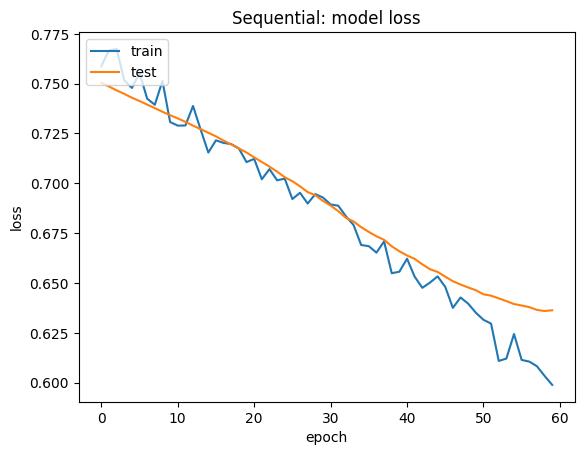

In [94]:
plt.plot(historyseq.history['loss'])
plt.plot(historyseq.history['val_loss'])
plt.title('Sequential: model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [95]:
import random
# Hacer predicciones en el conjunto de prueba
mytest=["lindo chicas las amo"]
mytest=np.array(mytest)
predictions = modelsequ.predict(mytest)

# Convertir las predicciones a etiquetas binarias (0 o 1)
binary_predictions = (predictions > 0.5).astype(int)

# Imprimir algunas predicciones
print(binary_predictions)



1/1 [==============================] - 0s 113ms/step
[[1]]


In [96]:
# Guardar el modelo en formato SavedModel
modelsequ.save("modeloIA.keras", save_format='keras')

In [120]:
def norm(cadena):
    cadena=corregir_texto(cadena)
    cadena=tokenization(cadena)
    cadena=remove_words(cadena)
    cadena=lemmatization(cadena)
    cadena=filter_words(cadena)
    return cadena

In [123]:
#CASO DE PRUEBA 2
cadena="ya me aburrí qué sueño"

mytest=[norm(cadena)]
mytest=np.array(mytest)
mymodel=load_model("modeloIA.keras")
predictions = mymodel.predict(mytest)

binary_predictions = (predictions > 0.5).astype(int)
print("Cadena \""+cadena+"\"" + " es:")
if binary_predictions: print("POSITIVO")
else: print("NEGATIVO")



1/1 [==============================] - 0s 106ms/step
Cadena "ya me aburrí qué sueño" es:
NEGATIVO
